# Market grows at night

Since its launch, Nifty’s intraday moves have cumulatively lost money. Net gains are due to overnight moves. This divergence expanded after the introduction of the pre-open market in 2010.

- Based on [While You Were Sleeping: What Stocks Do Overnight versus in Trading Hours](https://www.capitalmind.in/2019/10/while-you-were-sleeping-what-stocks-do-overnight-versus-in-trading-hours/) by [Deepak Shenoy](https://twitter.com/deepakshenoy)
- Prior Art: [Intraday change vs change between today's open & yesterday's close on Nifty](https://twitter.com/karanb_k/status/911933754003697664) by [Karan](https://twitter.com/karanb_k)

In [4]:
# Load dependencies

from bs4 import BeautifulSoup
import datetime
import matplotlib.pyplot as plt
import pandas
import requests

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

In [2]:
# Prepare data for analysis

def html_text_to_dataframe(html_text):
    '''
    Parse csv string from html into a pandas dataframe
    '''
    soup = BeautifulSoup(html_text, 'html.parser')
    csv_string = soup.find('div', {'id': 'csvContentDiv'}).text
    csv_fields, *csv_rows = [row.split(",") for row in csv_string.split(":")]
    csv_fields = [field.replace('"', '').strip() for field in csv_fields]
    csv_rows = [[val.replace('"', '').strip() for val in row] for row in csv_rows][:-1]
    df = pandas.DataFrame(csv_rows, columns = csv_fields)
    df['Date'] = pandas.to_datetime(df['Date'], format="%d-%b-%Y")
    df = df.set_index("Date", drop=True)
    df[csv_fields[1:]] = df[csv_fields[1:]].apply(pandas.to_numeric, errors='coerce', axis=1)
    return df


def get_index_data(index = "NIFTY 50", to_date = datetime.date.today(), data = pandas.DataFrame()):
    '''
    Recursively fetch all data for an index
    '''
    try:
        url = "https://www.nseindia.com/products/dynaContent/equities/indices/historicalindices.jsp"
        params = {
            'indexType': 'NIFTY 50',
            'toDate': to_date.strftime("%d-%m-%Y"),
            'fromDate': (to_date - datetime.timedelta(days=364)).strftime("%d-%m-%Y")
        }
        r = requests.get(url, params=params)
        df = html_text_to_dataframe(r.text)
        return get_index_data(index, to_date - datetime.timedelta(365), pandas.concat([data, df]))
    except:
        return data.dropna()
    
data = get_index_data()

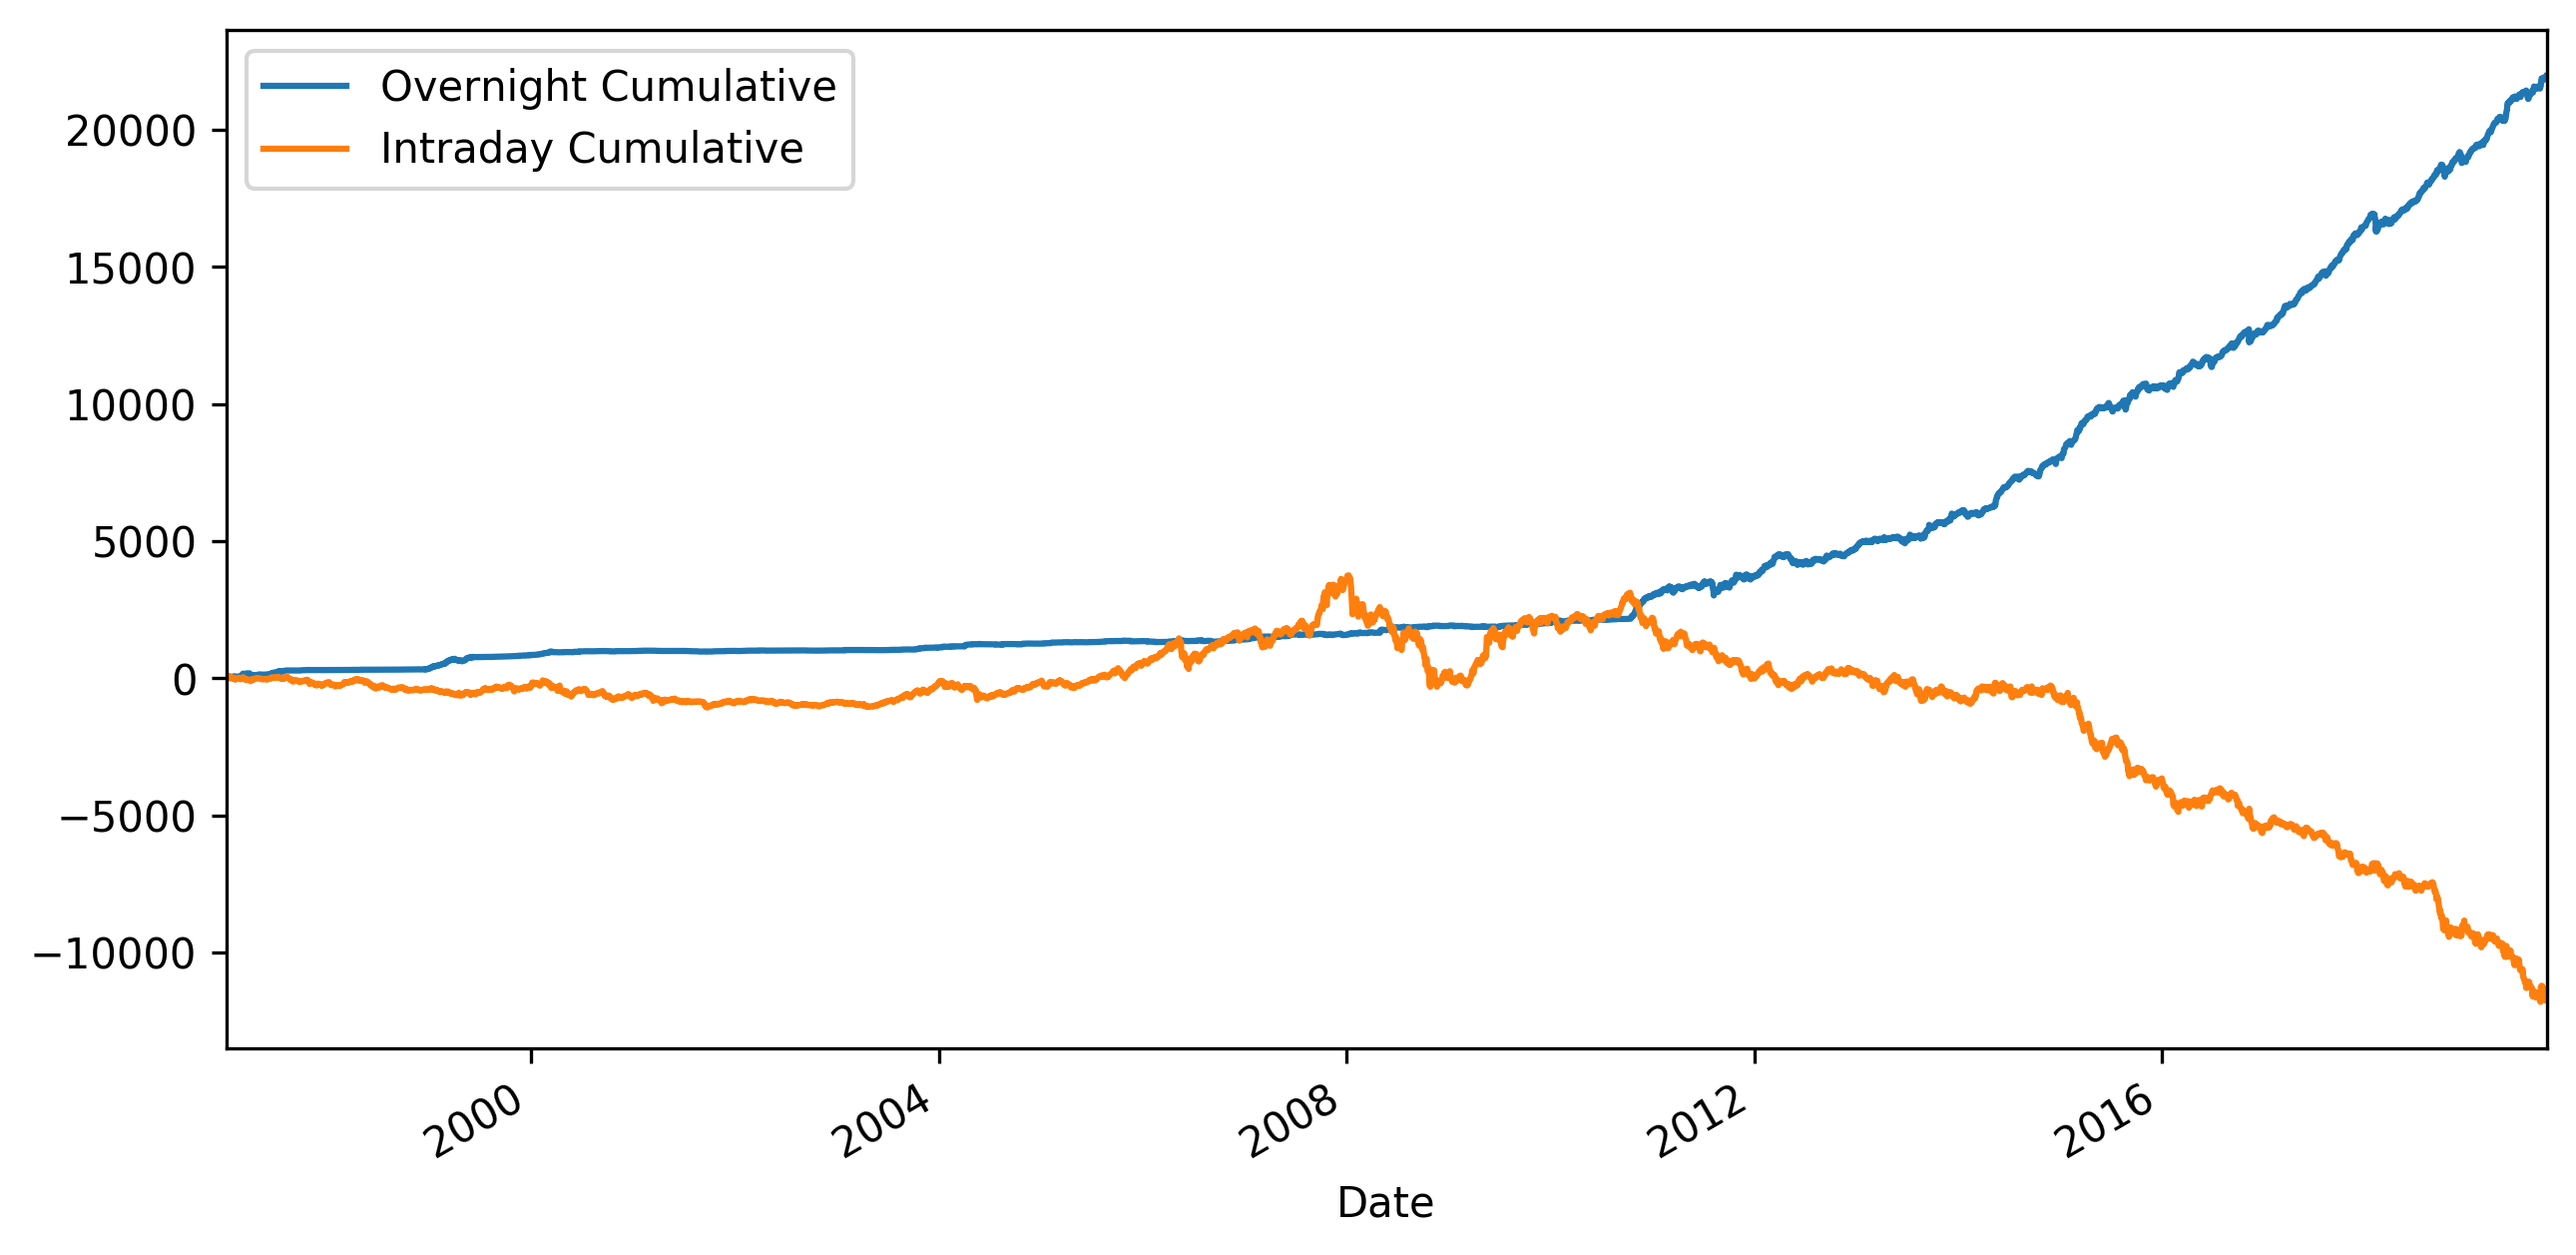

In [5]:
# Analysis

df = data
df = df.sort_index()

df["Overnight"] = df["Open"] - df["Close"].shift()
df["Intraday"] = df["Close"] - df["Open"]
df = df.dropna()[["Overnight", "Intraday"]]

df["Overnight Cumulative"] = df["Overnight"].cumsum()
df["Intraday Cumulative"] = df["Intraday"].cumsum()

df[["Overnight Cumulative", "Intraday Cumulative"]].plot()